###### Content under Creative Commons Attribution license CC-BY 4.0, code under MIT license © 2014 L.A. Barba, C.D. Cooper, G.F. Forsyth.  Based on [CFD Python](https://github.com/barbagroup/CFDPython), © 2013 L.A. Barba, also under CC-BY license.

# Relax and hold steady

Welcome to the second notebook of *"Relax and hold steady: elliptic problems"*, **Module 5** of the course [**"Practical Numerical Methods with Python"**](http://openedx.seas.gwu.edu/courses/GW/MAE6286/2014_fall/about). Are you relaxed yet?

In the [previous notebook](http://nbviewer.ipython.org/github/numerical-mooc/numerical-mooc/blob/master/lessons/05_relax/05_01_2D.Laplace.Equation.ipynb), you learned to use Jacobi iterations to solve Laplace's equation. The iterations *relax* the solution from an initial guess to the final, steady-state solution. You also saw again that the way we treat boundary conditions can influence our solution. Using a first-order approximation of the Neumann boundary messed up our spatial convergence in the whole domain! (We expected second-order spatial convergence from the central difference scheme, but we got closer to first order.) This was easily fixed by using a second-order scheme for the Neumann boundary. *It's always good to check that you get the expected order of convergence.*

A word of warning: in this course module, we will introduce a different use of the word *"convergence"*. Before, we used it to refer to the decay of the truncation errors (in space and time) with a decrease in the grid spacing ($\Delta x$ and $\Delta t$). Now, we also have a relaxation scheme, and we use the word convergence for the decay of the difference between two consecutive solutions (in some norm). Sometimes, this is called *algebraic convergence*. We'll concern ourselves with this in the next lesson. But first, let's play with Poisson.

## Poisson equation

The **Poisson equation** has a forcing function that drives the solution to its steady state. Unlike the Laplace equation, Poisson's equation involves finite values inside the field: 

$$\frac{\partial ^2 p}{\partial x^2} + \frac{\partial ^2 p}{\partial y^2} = b$$


In discretized form, this looks almost the same as [the Laplace Equation](./05_01_2D.Laplace.Equation.ipynb), except for the source term on the right-hand side:

$$\frac{p_{i+1,j}^{k}-2p_{i,j}^{k}+p_{i-1,j}^{k}}{\Delta x^2}+\frac{p_{i,j+1}^{k}-2 p_{i,j}^{k}+p_{i,j-1}^{k}}{\Delta y^2}=b_{i,j}^{k}$$

As before, we rearrange this to obtain an equation for $p$ at point $i,j$. 

$$p_{i,j}^{k+1}=\frac{(p_{i+1,j}^{k}+p_{i-1,j}^{k})\Delta y^2+(p_{i,j+1}^{k}+p_{i,j-1}^{k})\Delta x^2-b_{i,j}^{k}\Delta x^2\Delta y^2}{2(\Delta x^2+\Delta y^2)}$$

It's slightly more complicated than the Laplace equation, but nothing we can't handle.  

### An example problem

Let's consider the following Poisson equation:

\begin{equation}
\nabla^2 p = -2\left(\frac{\pi}{2}\right)^2\sin\left( \frac{\pi x}{L} \right) \cos\left(\frac{\pi y}{L}\right)
\end{equation}

in the domain 

$$\left\lbrace \begin{align*}
0 &\leq x\leq 1  \\
-0.5 &\leq y \leq 0.5 
\end{align*} \right.$$

with Dirichlet boundary conditions 

$$p=0 \text{ at } \left\lbrace 
\begin{align*}
x&=0\\
y&=0\\
y&=-0.5\\
y&=0.5
\end{align*} \right.$$

To solve this equation, we assume an initial state of $p=0$ everywhere, apply the boundary conditions and then iteratively relax the system until we converge on a solution.

To start, let's import libraries and set up our spatial mesh.

In [1]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot, cm
from math import pi
import numpy
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

In [2]:
# Parameters
nx = 41
ny = 41
xmin = 0
xmax = 1
ymin = -0.5
ymax = 0.5


l2_target = 1e-10

def initialize(nx, ny, xmax, xmin, ymax, ymin):
    '''Initialize the Poisson problem
    Parameters:
    ----------
    nx : int
        number of mesh points in x
    ny : int
        number of mesh points in y
    xmax: float
        maximum value of x in mesh
    xmin: float
        minimum value of x in mesh
    ymax: float
        maximum value of y in mesh
    ymin: float
        minimum value of y in mesh
    
    Returns:
    -------
    X  : 2D array of floats
        X-position of mesh
    Y  : 2D array of floats
        Y-position of mesh
    p_i: 2D array of floats
        initial guess of p
    b  : 2D array of floats
        forcing function
    dx : float
        mesh size in x direction
    dy : float
        mesh size in y direction
    '''

    dx = (xmax-xmin)/(nx-1)
    dy = (ymax-ymin)/(ny-1)

    # Mesh
    x  = numpy.linspace(xmin,xmax,nx)
    y  = numpy.linspace(ymin,ymax,ny)
    X,Y = numpy.meshgrid(x,y)

    # Source
    L = xmax-xmin
    b = -2*(pi/L)**2*numpy.sin(pi*X/L)*numpy.cos(pi*Y/L)

    # Initialize
    p_i  = numpy.zeros((ny,nx))

    return X, Y, x, y, p_i, b, dx, dy, L

The Jacobi iterations need an exit condition. We can use the same relative L2-norm that we wrote for the Laplace exit condition, so we saved the function into a helper Python file for easy importing.  

In [3]:
from laplace_helper import L2_rel_error

Now it's time to write the function to solve the Poisson equation.  Notice that all of the boundaries in this problem are Dirichlet boundaries, so no BC updates required!

There's also one extra piece we're adding in here.  To later examine the convergence of the iterative process, we will save the L2-norm of the difference between successive solutions. A plot of this quantity with respect to the iteration number will show us how fast the relaxation scheme is converging.

In [4]:
def poisson_2d(p, b, dx, dy, l2_target):
    '''Performs Jacobi relaxation
    
    Parameters:
    ----------
    p : 2D array of floats
        Initial guess
    b : 2D array of floats
        Source term
    dx: float
        Mesh spacing in x direction
    dy: float
        Mesh spacing in y direction
    l2_target: float
        Target difference between two consecutive iterates
    
    Returns:
    -------
    p: 2D array of float
        Distribution after relaxation
    '''

    l2_norm = 1
    iterations = 0
    l2_conv = []
    
    while l2_norm > l2_target:

        pd = p.copy()

        p[1:-1,1:-1] = 1/(2*(dx**2 + dy**2)) * \
                        ((pd[1:-1,2:]+pd[1:-1,:-2])*dy**2 +\
                        (pd[2:,1:-1] + pd[:-2,1:-1])*dx**2 -\
                         b[1:-1,1:-1]*dx**2*dy**2)
    
        # BCs are automatically enforced
        
        l2_norm = L2_rel_error(pd,p)
        iterations += 1
        l2_conv.append(l2_norm)
    
    print('Number of Jacobi iterations: {0:d}'.format(iterations))
    return p, l2_conv        

The `initialize` function above sets the array `p_i` to all zeros for an initial guess at the solution.  We can use the `plot_3D` function we wrote in the previous notebook to explore the field $p$, before and after the relaxation. We saved this plotting function into the helper Python file, so we can re-use it here.

In [5]:
from laplace_helper import plot_3D

Now we initialize all of the problem variables and plot!

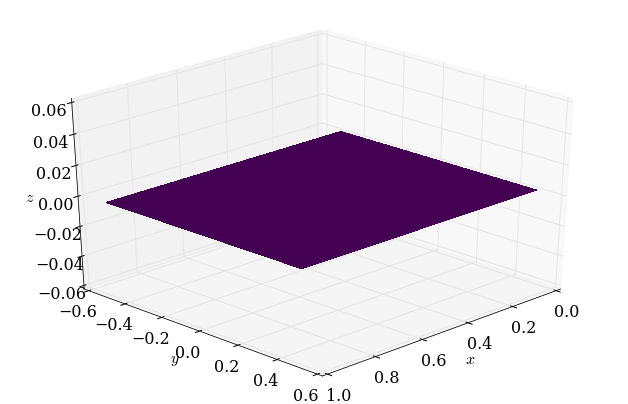

In [6]:
X, Y, x, y, p_i, b, dx, dy, L = initialize(nx, ny, xmax, xmin, ymax, ymin)
plot_3D(x, y, p_i)

That looks suitably boring.  Zeros everywhere and boundaries held at zero.  If this were a Laplace problem we would already be done!  

But the Poisson problem has a source term that will evolve this zero initial guess to something different. Let's run our relaxation scheme and see what effect the forcing function has on `p`.

In [7]:
p, l2_conv = poisson_2d(p_i.copy(), b, dx, dy, l2_target)

Number of Jacobi iterations: 5587


It took 5,587 iterations to converge to the exit criterion (that's quite a lot, don't you think? Let's now take a look at a plot of the final field:

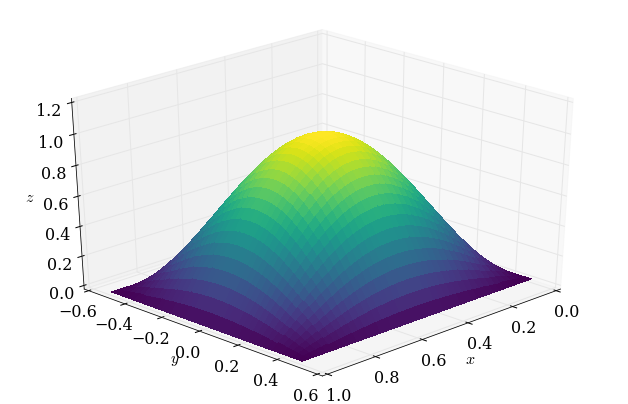

In [8]:
plot_3D(x,y,p)

Something has definitely happened.  That looks good, but what about the error? This problem has the following analytical solution:

\begin{equation}
p(x,y) = \sin{\left(\frac{x\pi}{L} \right)}\cos{\left(\frac{y\pi}{L} \right)}
\end{equation}

Time to compare the calculated solution to the analytical one. Let's do that.

In [9]:
def p_analytical(X,Y,L):
    ''' Computes analytical solution to Poisson problem
    Parameters:
    ----------
    X: 2D array of float
        Mesh with x components
    Y: 2D array of float
        Mesh with y components
    L: float
        Size of domain
    Returns:
    -------
    Analytical solution
    '''
    return numpy.sin(X*pi/L)*numpy.cos(Y*pi/L)

In [10]:
p_an = p_analytical(X,Y,L)

In [11]:
error = L2_rel_error(p,p_an)
error

0.00051416820220736182

That seems small enough. Of course, each application problem can have different accuracy requirements.

### Algebraic convergence

Remember that we saved the L2-norm of the difference between two consecutive iterations. The purpose of that was to look at how the relaxation scheme *converges*, in algebraic sense: with consecutive solutions getting closer and closer to each other. Let's use a line plot for this.

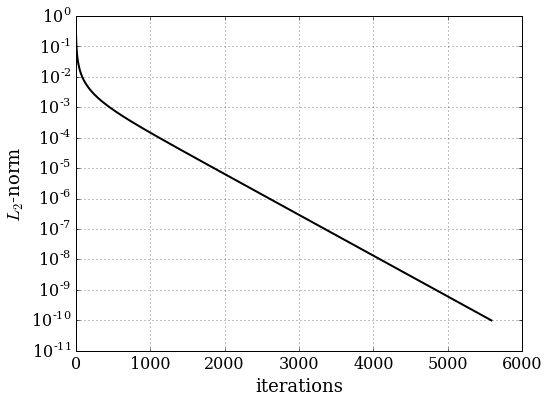

In [12]:
pyplot.figure(figsize=(8,6))
pyplot.grid(True)
pyplot.xlabel(r'iterations', fontsize=18)
pyplot.ylabel(r'$L_2$-norm', fontsize=18)
pyplot.semilogy(numpy.arange(len(l2_conv)), l2_conv, lw=2, color='k');

It looks like in the beginning, iterations started converging pretty fast, but they quickly adopted a slower rate. As we saw before, it took more than 5,000 iterations to get to our target of $10^{-10}$ difference between two consecutive solutions (in L2-norm). That is a *lot* of iterations, and we would really like to relax faster! No worries, we'll learn to do that in the next notebook.

### Spatial convergence

For a sanity check, let's make sure the solution is achieving the expected second-order convergence in space.

In [13]:
nx_values = numpy.asarray([11,21,41,81])
ny_values = numpy.asarray([11,21,41,81])

error = numpy.zeros(len(nx_values))

for i in range(len(nx_values)):
    
    nx = nx_values[i]
    ny = ny_values[i]
    
    X, Y, c, y, p_i, b, dx, dy, L = initialization(nx, ny, xmax, xmin, ymax, ymin)
    p, l2_conv = poisson_2d(p_i.copy(), b, dx, dy, l2_target)

    p_an = p_analytical(X,Y,L)
    
    error[i] = L2_rel_error(p,p_an)

Number of Jacobi iterations: 400
Number of Jacobi iterations: 1505
Number of Jacobi iterations: 5587
Number of Jacobi iterations: 20563


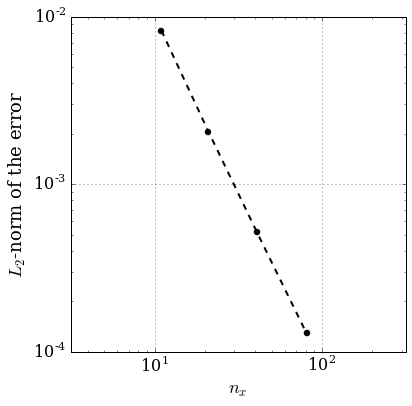

In [14]:
pyplot.figure(figsize=(6,6))
pyplot.grid(True)
pyplot.xlabel(r'$n_x$', fontsize=18)
pyplot.ylabel(r'$L_2$-norm of the error', fontsize=18)
pyplot.loglog(nx_values, error, color='k', ls='--', lw=2, marker='o')
pyplot.axis('equal');

That looks pretty much second order!  Remember that the boundary conditions can adversely affect convergence, but Dirichlet boundaries are "exact" and will never impact your convergence.  

***

In [15]:
from IPython.core.display import HTML
css_file = '../../styles/numericalmoocstyle.css'
HTML(open(css_file, "r").read())